# 代码与金融分析

在这节课程你将构建两个Agent，他们将合作解决手头的任务同时请求你的反馈。第一个Agent将使用llm生成代码，第二个Agent则负责执行代码。

<center>
<img src="images/writer_and_executor.png" width="600">
</center>

## 设置配置
本节我们使用`gpt-4-turbo`创建Agent。

In [1]:
llm_config={"model": "gpt-4-turbo"}

## 创建代码执行器


In [2]:
from autogen.coding import LocalCommandLineCodeExecutor
# 该类通过命令行执行代码

我们通过输入`timeout`与`work_dir`等配置信息来实例化代码执行器，其中`timeout`为等待代码执行的时间默认为60秒，`work_dir`为代码执行的目录，可以在该目录下查看代码与代码执行的中间结果。

In [3]:
executor = LocalCommandLineCodeExecutor(
    timeout=60,
    work_dir="coding",
)

## 创建Agent

In [4]:
from autogen import ConversableAgent, AssistantAgent

### 1. 代码执行Agent
创建一个负责执行代码的Agent，该Agent基于刚才创建的代码执行器，并不使用大模型，因此设置`llm_config`为`False`；`human_input_mode`人类输入模式设置为`ALWAYS`，因此Agent在每次执行代码前都需要人工确认；通过设置`default_auto_reply`默认自动回复为`Please continue. If everything is done, reply 'TERMINATE'.`来让Agent在检测不到代码时对代码编写Agent发送我们设置的回复。

In [5]:
code_executor_agent = ConversableAgent(
    name="code_executor_agent",
    llm_config=False,
    code_execution_config={"executor": executor},
    human_input_mode="ALWAYS",
    default_auto_reply=
    "Please continue. If everything is done, reply 'TERMINATE'.",
)

### 2. 代码编写Agent
创建一个编写代码的Agent，该Agent接入我们之前设置的`gpt-4-turbo`，因为它只负责编写代码所以我们将它的`code_execution_config`代码执行器配置设置为`False`，将`human_input_mode`人类输入模式设置为`NEVER`来让它运行时候不需要人类输入。
AssistantAgent 是 ConversableAgent 的子类，相比起ConversableAgent，AssistantAgent的系统消息更适合让Agent通过撰写代码的方式完成任务。

In [6]:
code_writer_agent = AssistantAgent(
    name="code_writer_agent",
    llm_config=llm_config,
    code_execution_config=False,
    human_input_mode="NEVER",
)

[autogen.oai.client: 06-02 23:32:21] {129} WARNING - The API key specified is not a valid OpenAI format; it won't work with the OpenAI-hosted model.


如果你对代码编写Agent好奇，我们可以打印它的系统消息来查看它最开始接受的系统消息。

In [7]:
code_writer_agent_system_message = code_writer_agent.system_message

In [8]:
print(code_writer_agent_system_message)

You are a helpful AI assistant.
Solve tasks using your coding and language skills.
In the following cases, suggest python code (in a python coding block) or shell script (in a sh coding block) for the user to execute.
    1. When you need to collect info, use the code to output the info you need, for example, browse or search the web, download/read a file, print the content of a webpage or a file, get the current date/time, check the operating system. After sufficient info is printed and the task is ready to be solved based on your language skill, you can solve the task by yourself.
    2. When you need to perform some task with code, use the code to perform the task and output the result. Finish the task smartly.
Solve the task step by step if you need to. If a plan is not provided, explain your plan first. Be clear which step uses code, and which step uses your language skill.
When using code, you must indicate the script type in the code block. The user cannot provide any other feed

## 执行任务

让两个Agent合作完成股票分析。

In [9]:
import datetime

today = datetime.datetime.now().date()
weekday = datetime.date.today().weekday()
message = f"今天是 {today}, 周{weekday + 1}. "\
"创建一个图表，显示NVDA和TLSA到今天的股票收益。请注意，股票不会在周末交易。"\
"确保代码在markdown代码块中并保存图片"\
"到文件 ytd_stock_gains.png 中。"""

In [10]:
chat_result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message=message,
)

code_executor_agent (to code_writer_agent):

今天是 2024-06-02, 周6. 创建一个图表，显示NVDA和TLSA到今天的股票收益。请注意，股票不会在周末交易。确保代码在markdown代码块中并保存图片到文件 ytd_stock_gains.png 中。

--------------------------------------------------------------------------------
code_writer_agent (to code_executor_agent):

首先，我们需要获取NVIDIA和Tesla的股票数据。在获取数据之前，我们需要计划如何处理数据并将结果保存为图表。这里是我们将要执行的步骤：

1. 设置Python环境并安装所需的库。
2. 获取NVIDIA和Tesla自年初至2024-05-31的股票数据，因为股票市场在周末不交易。
3. 使用收盘价格数据计算从年初到最新的收益。
4. 绘制股票收益图，并保存为PNG文件。

现在，让我们先确保您的Python环境已经安装了需要用到的库。如果还未安装，我会提供安装指令。复制以下代码到Python环境中执行，以检查并安装缺失的库。

```python
# filename: check_and_install_libraries.py
import subprocess
import pkg_resources

required = {'yfinance', 'matplotlib', 'pandas'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

pr

**注意**: 你的运行结果可能与notebook中的不一样，并且在过程中有可能产生带有错误的代码。不过，它们最终会提供正确的代码。

## 显示图像
现在让我们导入图像并将它显示。
**注意**: 
* 你的绘图可能与上次运行结果显示的不同，因为LLM的自由式代码生成可以选择不同的绘图类型，例如条形图。
* 你可以重新运行上一个单元格并检查生成的代码。如果它生成的是条形图，请记住，你可以直接指定你喜欢的图形类型，而不是条形图。

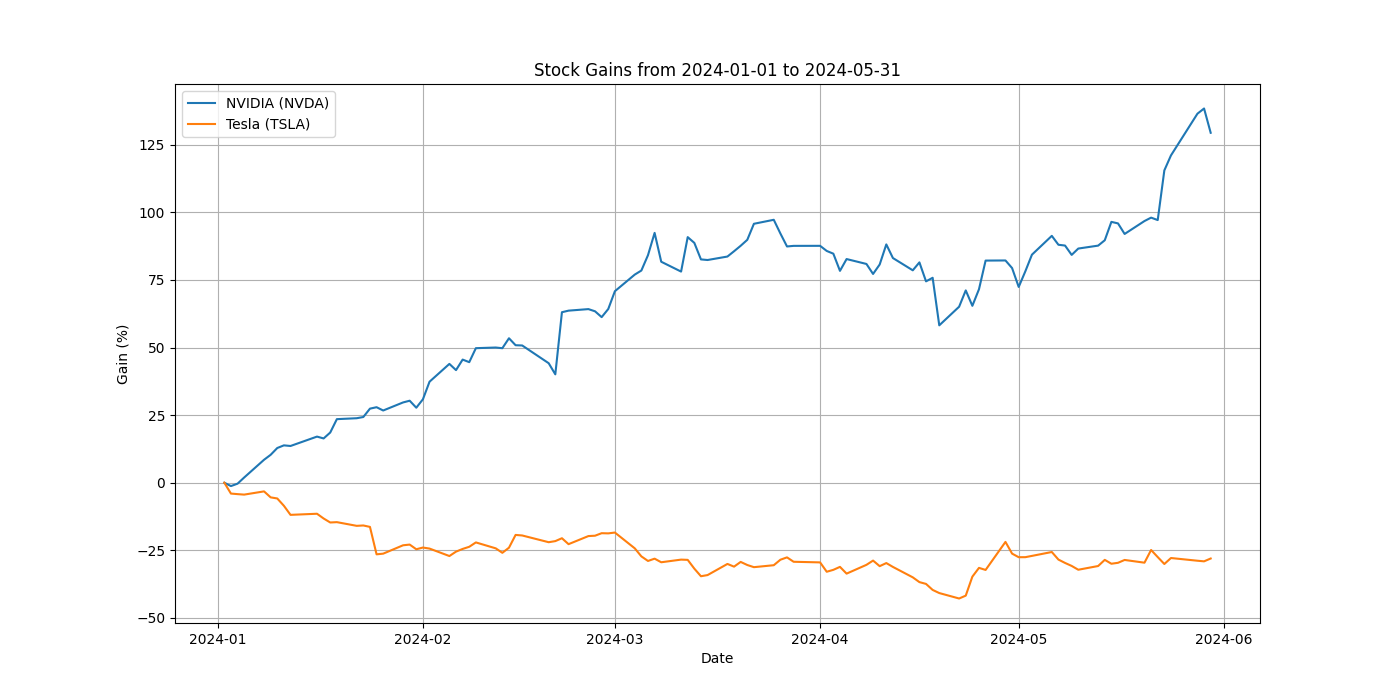

In [11]:
import os
from IPython.display import Image

Image(os.path.join("coding", "ytd_stock_gains.png"))

**注意**: 代理将自动将代码保存在.py文件中，并将绘图保存在.png文件中。要访问和检查代理生成的文件，可以打开`coding`文件夹以找到所有生成的文件。

## 用户自定义函数

如果你想更多地控制如何完成这个任务，你可以为这两个任务定义函数，并让Agent在代码中调用这些函数，而不是要求Agent每次都生成下载股票数据和绘制图表的代码。

In [12]:
def get_stock_prices(stock_symbols, start_date, end_date):
    """获取给定股票符号在开始和结束日期之间的股票价格

    Args:
        stock_symbols (str or list): 用来获取价格的股票符号
        start_date (str): 起始日期的格式为'YYYY-MM-DD'
        end_date (str): 结束日期，格式为'YYYY-MM-DD'.
    
    Returns:
        pandas.DataFrame: 给定股票符号的股票价格按日期索引，每个股票符号一列
    """
    import yfinance    #导入yfinance

    stock_data = yfinance.download(         #下载数据 
        stock_symbols, start=start_date, end=end_date
    )
    return stock_data.get("Close")

In [13]:
def plot_stock_prices(stock_prices, filename):
    """绘制给定股票符号的股票价格

    Args:
        stock_prices (pandas.DataFrame): 给定股票符号的股票价格
    """
    import matplotlib.pyplot as plt 

    plt.figure(figsize=(10, 5))
    for column in stock_prices.columns:
        plt.plot(
            stock_prices.index, stock_prices[column], label=column
                )
    plt.title("Stock Prices")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.savefig(filename)

### 使用自定义的函数创建新的代码执行器

In [14]:
executor = LocalCommandLineCodeExecutor(
    timeout=60,
    work_dir="coding",
    functions=[get_stock_prices, plot_stock_prices],# 把刚定义的函数添加到执行器中
)

我们同时也要让code_writer Agent 知道函数的存在，因此把定义的函数添加到prompt中，方便Agent理解。

In [15]:
code_writer_agent_system_message += executor.format_functions_for_prompt()
print(code_writer_agent_system_message)

You are a helpful AI assistant.
Solve tasks using your coding and language skills.
In the following cases, suggest python code (in a python coding block) or shell script (in a sh coding block) for the user to execute.
    1. When you need to collect info, use the code to output the info you need, for example, browse or search the web, download/read a file, print the content of a webpage or a file, get the current date/time, check the operating system. After sufficient info is printed and the task is ready to be solved based on your language skill, you can solve the task by yourself.
    2. When you need to perform some task with code, use the code to perform the task and output the result. Finish the task smartly.
Solve the task step by step if you need to. If a plan is not provided, explain your plan first. Be clear which step uses code, and which step uses your language skill.
When using code, you must indicate the script type in the code block. The user cannot provide any other feed

### 使用新的系统消息更新代理

In [16]:
code_writer_agent = ConversableAgent(
    name="code_writer_agent",
    system_message=code_writer_agent_system_message,    # 传入新的prompt
    llm_config=llm_config,
    code_execution_config=False,
    human_input_mode="NEVER",
)

[autogen.oai.client: 06-02 23:32:53] {129} WARNING - The API key specified is not a valid OpenAI format; it won't work with the OpenAI-hosted model.


In [17]:
code_executor_agent = ConversableAgent(
    name="code_executor_agent",
    llm_config=False,
    code_execution_config={"executor": executor},
    human_input_mode="ALWAYS",
    default_auto_reply=
    "Please continue. If everything is done, reply 'TERMINATE'.",
)

### 使用新代理执行任务

In [18]:
chat_result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message=f"今天是{today}, 周{weekday}。"
    "下载NVDA和TSLA的股票价格并绘制图表"
    "确保代码在markdown代码块中，并将图形保存到文件"
    " file stock_prices_YTD_plot.png 中.",
)

code_executor_agent (to code_writer_agent):

今天是2024-06-02, 周6。下载NVDA和TSLA的股票价格并绘制图表确保代码在markdown代码块中，并将图形保存到文件 file stock_prices_YTD_plot.png 中.

--------------------------------------------------------------------------------
code_writer_agent (to code_executor_agent):

为了完成任务，我们将遵循以下步骤：

1. 从 `functions` 模块导入 `get_stock_prices` 和 `plot_stock_prices` 函数。
2. 定义起止日期来获取年初至今的股票价格数据。起始日期是本年的1月1日，即2024年，结束日期是今天，即2024年6月2日。
3. 使用 `get_stock_prices` 函数下载 NVIDIA (NVDA) 和 Tesla (TSLA) 的股票价格数据。
4. 使用 `plot_stock_prices` 函数将股票价格绘图，并保存到文件 `stock_prices_YTD_plot.png` 中。

先执行以下 Python 代码来获取和绘制股票价格数据：

```python
# filename: fetch_and_plot_stocks.py
from functions import get_stock_prices, plot_stock_repices

# 定义股票代码和日期范围
stock_symbols = ["NVDA", "TSLA"]
start_date = "2024-01-01"
end_date = "2024-06-02"

# 获取股票价格数据
stock_prices = get_stock_prices(stock_symbols, start_date, end_date)

# 绘制股票价格图表并保存到文件
plot_stock_prices(stock_prices, "stock_prices_YTD_plot.png")
print("Stock prices plotted and saved to

### 绘制结果

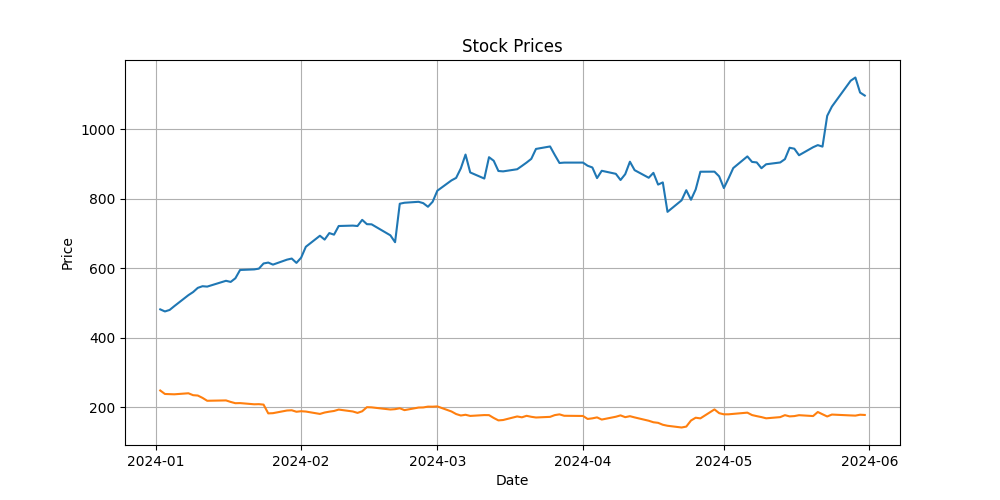

In [19]:
Image(os.path.join("coding", "stock_prices_YTD_plot.png"))

总结：我们学习了两种代码生成的方式，一种是基于默认的AssistantAgent，另一种是基于额外提供的用户自定义函数。代码生成能力是一种通用的能力，可以用来执行许多不同的任务，你可以探索更多关于不同种类的代码执行器，或者为不同的语言或执行环境定义自己的代码执行器。

**注意**: 代理将自动将代码保存在.py文件中，并将绘图保存在.png文件中。要访问和检查代理生成的文件，可以打开`coding`文件夹以找到所有生成的文件。